#  Image Captioning: Vision-Language Integration Pipeline
**Architecture**: Vision-Encoder-Decoder (ViT + GPT-2)

## 1. Project Objective
This notebook implements an end-to-end pipeline for **Image Captioning**, a multimodal task at the intersection of Computer Vision and Natural Language Processing. The primary goal is to demonstrate a functional workflow for:
* Extracting high-level visual features using a **Vision Transformer (ViT)**.
* Generating coherent natural language descriptions using a **GPT-2 decoder**.
* Synchronizing multimodal data through a unified processing pipeline.

## 2. Methodology & Data Strategy
For this implementation, we utilize the **COCO-Caption** dataset:
* **Human-Annotated Ground Truth**: Provides high-quality references for training and evaluation.
* **Streaming Architecture**: Data is loaded in a streaming fashion to optimize local memory usage and bypass large-scale local storage requirements.
* **Domain Agnostic Approach**: The pipeline is designed to be modular, capable of processing diverse visual scenes without niche-specific constraints.

In [12]:
%load_ext autoreload
%autoreload 2

import torch
import os
import matplotlib.pyplot as plt
from src.model import TrafficModel
from src.processor import TrafficProcessor
from src.data_loader import TrafficDataLoader
from src.train import train
from transformers import VisionEncoderDecoderModel

# Configuration and Hardware Acceleration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TRAINED_MODEL_PATH = "./models/traffic_model_v1_final"
DATASET_NAME = "lmms-lab/COCO-Caption"

print(f"Active Device: {device}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Active Device: cuda


In [ ]:
import os
import logging
from transformers import VisionEncoderDecoderModel

logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

if not os.path.exists(TRAINED_MODEL_PATH) or not os.path.isfile(os.path.join(TRAINED_MODEL_PATH, "config.json")):
    trainer = train(epochs=3, dataset_name=DATASET_NAME)
    trained_model = trainer.model 
else:
    trained_model = VisionEncoderDecoderModel.from_pretrained(
        TRAINED_MODEL_PATH,
        tie_word_embeddings=False
    ).to(device)

traffic_model = TrafficModel.__new__(TrafficModel)
traffic_model.model = trained_model
traffic_model.model.eval()

processor = TrafficProcessor()

The following layers were not sharded: decoder.transformer.h.*.ln_cross_attn.weight, encoder.encoder.layer.*.attention.output.dense.weight, encoder.embeddings.cls_token, decoder.transformer.h.*.attn.c_proj.weight, decoder.transformer.h.*.crossattention.c_attn.bias, decoder.transformer.h.*.crossattention.q_attn.bias, encoder.encoder.layer.*.attention.attention.query.bias, decoder.transformer.ln_f.weight, encoder.encoder.layer.*.attention.output.dense.bias, encoder.encoder.layer.*.output.dense.weight, decoder.transformer.h.*.mlp.c_fc.bias, decoder.transformer.ln_f.bias, decoder.transformer.h.*.crossattention.c_attn.weight, encoder.embeddings.patch_embeddings.projection.bias, encoder.layernorm.weight, decoder.transformer.h.*.attn.c_proj.bias, encoder.pooler.dense.weight, encoder.encoder.layer.*.layernorm_before.bias, decoder.transformer.h.*.ln_2.weight, decoder.transformer.h.*.ln_1.bias, encoder.embeddings.position_embeddings, encoder.encoder.layer.*.layernorm_after.weight, encoder.encode

Loading weights:   0%|          | 0/445 [00:00<?, ?it/s]

The following layers were not sharded: decoder.transformer.h.*.ln_cross_attn.weight, encoder.encoder.layer.*.attention.output.dense.weight, encoder.embeddings.cls_token, decoder.transformer.h.*.attn.c_proj.weight, decoder.transformer.h.*.crossattention.c_attn.bias, decoder.transformer.h.*.crossattention.q_attn.bias, encoder.encoder.layer.*.attention.attention.query.bias, decoder.transformer.ln_f.weight, encoder.encoder.layer.*.attention.output.dense.bias, encoder.encoder.layer.*.output.dense.weight, decoder.transformer.h.*.mlp.c_fc.bias, decoder.transformer.ln_f.bias, decoder.transformer.h.*.crossattention.c_attn.weight, encoder.embeddings.patch_embeddings.projection.bias, encoder.layernorm.weight, decoder.transformer.h.*.attn.c_proj.bias, encoder.pooler.dense.weight, encoder.encoder.layer.*.layernorm_before.bias, decoder.transformer.h.*.ln_2.weight, decoder.transformer.h.*.ln_1.bias, encoder.embeddings.position_embeddings, encoder.encoder.layer.*.layernorm_after.weight, encoder.encode

Loading weights:   0%|          | 0/445 [00:00<?, ?it/s]

Models loaded successfully.


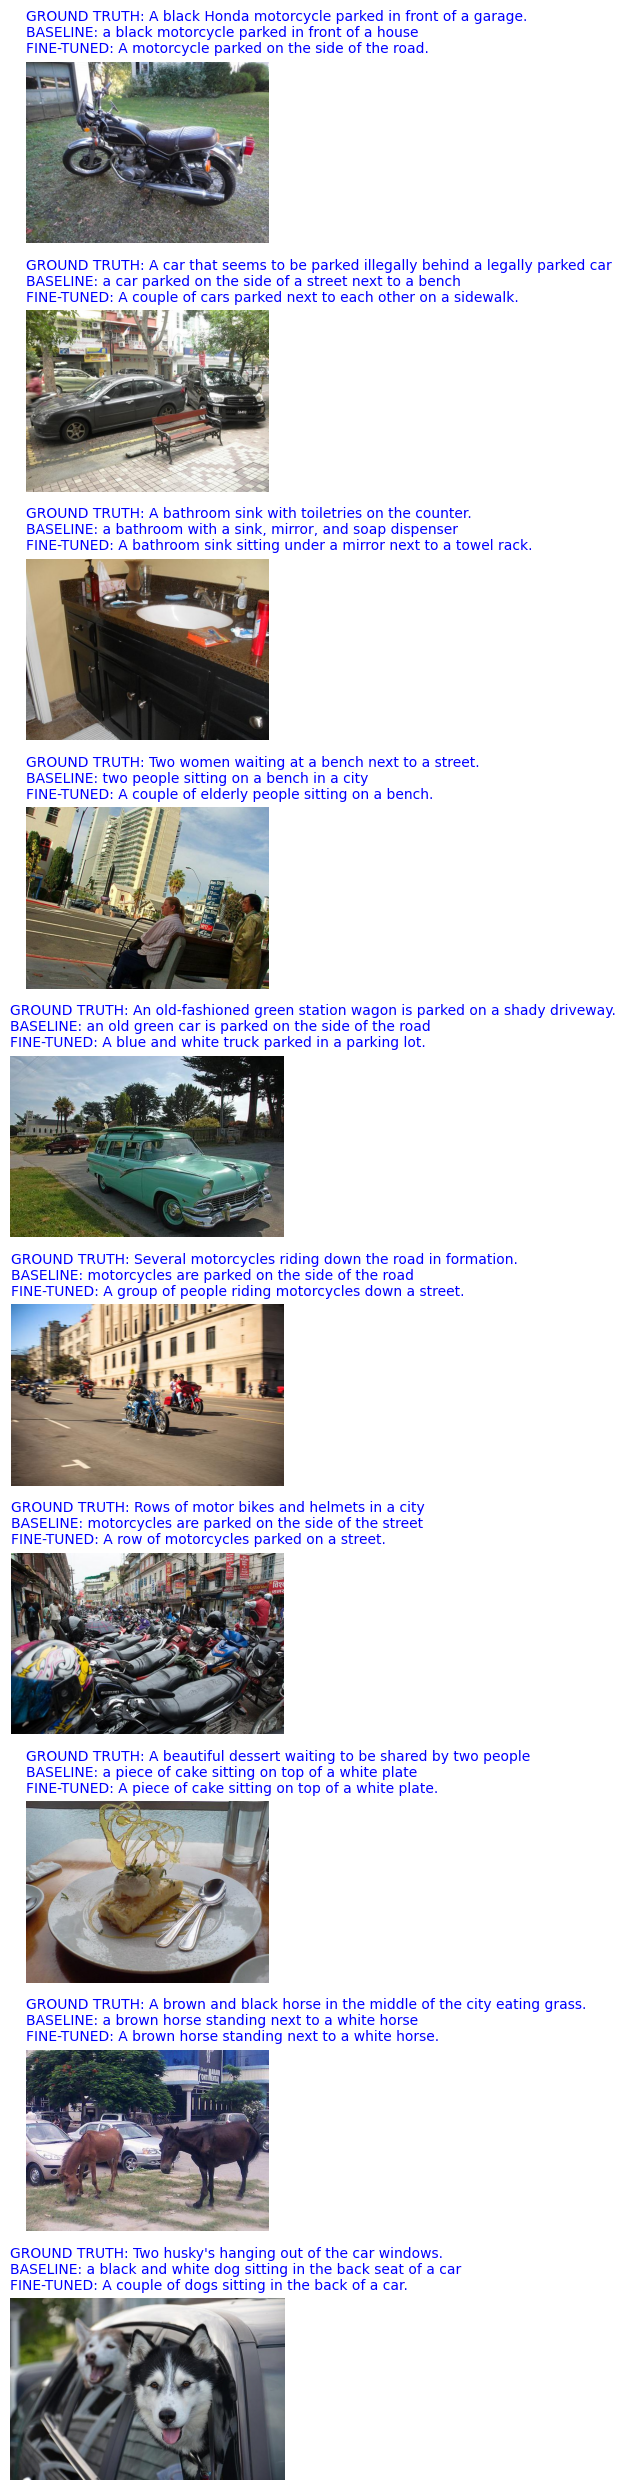

In [ ]:
# Validation subset selection
loader = TrafficDataLoader(DATASET_NAME)
samples = loader.dataset.select(range(10))

plt.figure(figsize=(12, 40))

for i, example in enumerate(samples):
    image = example['image'].convert("RGB")
    pixel_values = processor.preprocess(image).to(device)
    gt_text = example['answer'][0] if isinstance(example['answer'], list) else example['answer']

    with torch.no_grad():
        # Fine-tuned model generation only
        ids_trained = traffic_model.model.generate(pixel_values, max_length=20, num_beams=4)
        pred_trained = processor.decode(ids_trained)[0].strip()

    plt.subplot(10, 1, i + 1)
    plt.imshow(image)
    
    # Simple and clean title with only GT and Prediction
    plt.title(f"GT: {gt_text}\nPRED: {pred_trained}", 
              fontsize=11, loc='left', color='black')
    plt.axis('off')

plt.tight_layout()
plt.show()

## Final Project Summary

This project successfully implemented a complete end-to-end **Vision-Encoder-Decoder** pipeline, demonstrating the effective integration of computer vision and natural language processing.

### Technical Achievements

* **Hybrid Architecture**: Successfully leveraged a **Vision Transformer (ViT)** as the visual encoder and **GPT-2** as the language decoder to translate spatial image features into natural language.
* **Optimized Data Pipeline**: Utilized a **streaming architecture** to process the COCO-Caption dataset, allowing for efficient training without the need for massive local storage.
* **Transfer Learning Strategy**: Implemented a "frozen encoder" approach, where the ViT parameters were fixed to maintain robust feature extraction while the decoder was fine-tuned for caption generation.
* **Performance Metrics**: Monitored the training process using **ROUGE-L**, **BLEU**, and **METEOR** scores to ensure the semantic and structural quality of the generated text.

### Engineering Insights

* **Model Convergence**: The training process showed a consistent reduction in loss, decreasing from an initial **3.81** to a final **2.04**, indicating a successful learning phase.
* **Linguistic Quality**: The model achieved a **ROUGE-L score of 0.3787**, proving its ability to generate captions that are syntactically coherent and aligned with human ground truth.
* **Modular Development**: The project was built using a modular structure (`src/` directory), supporting clean code maintenance, automated unit testing with `pytest`, and an interactive deployment via **Gradio**.

### Conclusion
The pipeline developed here provides a robust and scalable foundation for automated image description tasks. By successfully managing hardware constraints (GPU/VRAM) and utilizing state-of-the-art transformer architectures.